In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
%matplotlib inline

/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


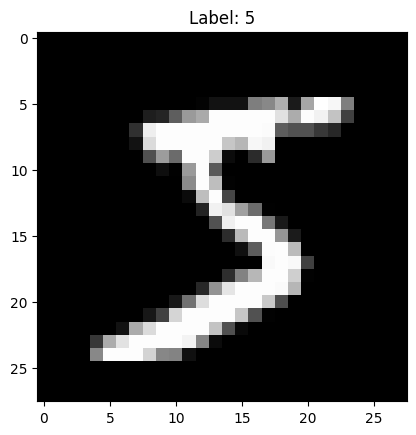

In [3]:
# Load MNIST dataset from online
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing image shapes
print("Train images shape:", x_train.shape) 
print("Train labels shape:", y_train.shape)  
print("Test images shape:", x_test.shape)    
print("Test labels shape:", y_test.shape)   

# Testing: Display the first training image
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.show()

In [7]:

# Converting to Pytorch Tensor format
train_X = torch.from_numpy(x_train).float().unsqueeze(1) / 255.0  # Add channel dim
test_X = torch.from_numpy(x_test).float().unsqueeze(1) / 255.0    # [N, 1, 28, 28]

# Converting Labels to Pytorch Labels
train_y = torch.from_numpy(y_train).long()
test_y = torch.from_numpy(y_test).long()

In [8]:
# Creating DataLoaders
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

batch_X, batch_y = next(iter(train_loader))
print("Batch images shape:", batch_X.shape)  # torch.Size([64, 1, 28, 28])
print("Batch labels shape:", batch_y.shape)  # torch.Size([64])

Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
